# Туториал по двухэтапной модели

In [ ]:
# import sys

# !{sys.executable} -m pip install -r requirements.txt
# !jupyter nbextension enable --py widgetsnbextension

In [4]:
import datetime
import dill
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from zipfile import ZipFile
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 20)

# 📺 Данные: датасет КИОН

- просмотры фильмов и сериалов в приложении KION
- данные о пользователях
- данные об айтемах (фильмы, сериалы и т.д.)
 

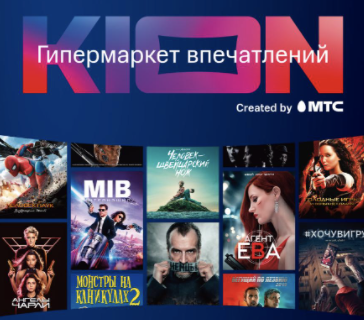

## Загрузим данные

In [5]:
PATH_TO_DATA = "../data_kion.zip"

with ZipFile(PATH_TO_DATA) as z:
    
    with z.open("data_kion/interactions_df.csv") as f:
        interactions = pd.read_csv(f)
    
    with z.open("data_kion/items.csv") as f:
        items = pd.read_csv(f)
        
    with z.open("data_kion/users.csv") as f:
        users = pd.read_csv(f)

# 🎛 EDA

## `interactions`: взаимодействия пользователь - айтем 
- с датой `last_watch_dt`
- длительностью просмотра `total_dur`
- % просмотра `watched_pct`

In [6]:
interactions.head(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [7]:
# обработка даты
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


In [8]:
max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()

print(f"min дата в interactions: {min_date}")
print(f"max дата в interactions: {max_date}")

min дата в interactions: 2021-03-13
max дата в interactions: 2021-08-22


## `users`: данные о пользователях

- `age` бин по возрасту 
- `income` бин по доходу 
- `sex` пол 
- `kids_flg` флаг наличия детей

Все признаки - результат предсказания соцдем моделей

In [9]:
users.head(5)

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [10]:
f"Уникальных юзеров в users: {users.shape[0]:_}"

'Уникальных юзеров в users: 840_197'

## `items`: данные об айтемах

- `content_type` - тип контента
- `title` - название на русском
- `title_orig` - название оригинальное
- `release_year` - год выпуска
- `countries` - страны
- `for_kids` - флаг контент для детей
- `age_rating`- Возрастной рейтинг
- `studios` - студии
- `directors` - режиссеры
- `actors`- актеры
- `keywords` - ключевые слова 
- `description` - описание

In [11]:
items.head(3)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежны...",Испания,NaN,16.0,NaN,Педро Альмодовар,Адольфо Фернанде...,Мелодрама легенд...,"Поговори, ней, 2..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, прик...",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брай...",Уморительная сов...,"Голые, перцы, 20..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубе...",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Да...",Профессиональный...,"Тактическая, сил..."


In [12]:
f"Уникальных айтемов в items {items.shape[0]:_}"

'Уникальных айтемов в items 15_963'

# ✂️ Схема валидации 
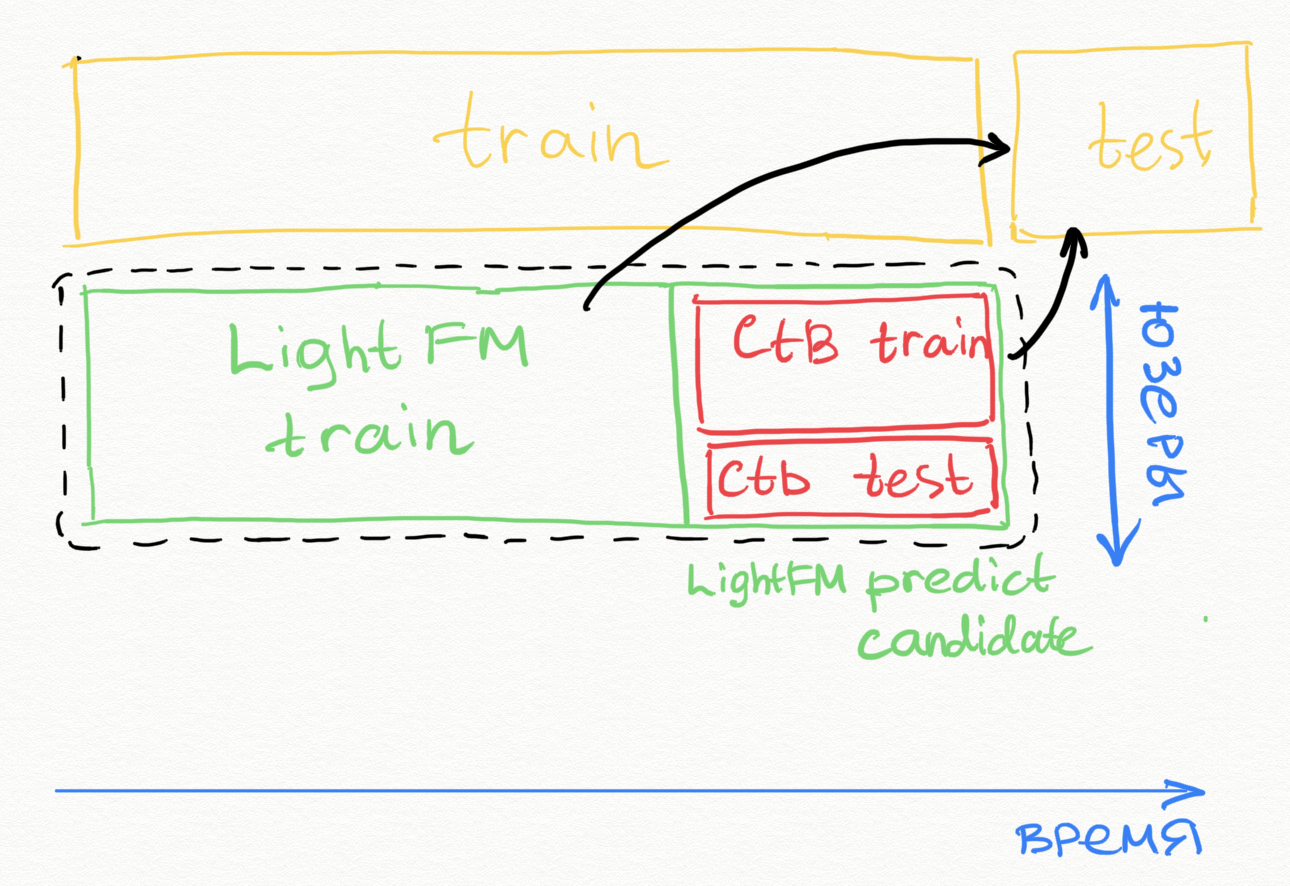

## Глобальный train - test

На `test` будем проверять результат обоих моделей:
-  отдельно модели 1го уровня: LightFM
- отдельно двухуровненой модели: LightFM + Catboost

На test оставим 7 дней

In [13]:
train = interactions[(interactions['last_watch_dt'] < max_date - pd.Timedelta(days=7))]
test = interactions[(interactions['last_watch_dt'] >= max_date - pd.Timedelta(days=7))]

# дополнительная фильтрация train для исключения случайных просмотров 
train = train[train['total_dur'] >= 300]

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (3832711, 5)
test: (490982, 5)


# 1️⃣ 1 этап: LightFM

- обучаем LightFM user2item модель на LighFM train

- делаем предикт c кандидатами на LighFM predict



## Разделим данные для LightFM еще на 2 части

### train + pred for candidates 

Разделим данные на `lfm_train` и `lfm_pred` как 60%-40% по квантилю даты просмотра 

(Считаем, что гиперпараметры оптимальной lfm модели мы уже подобрали)

На `lfm_pred` будем в дальнейшем обучать бустинг - модель 2 этапа

In [14]:
lfm_date_threshold = train['last_watch_dt'].quantile(q=0.6, interpolation='nearest')
lfm_date_threshold

datetime.date(2021, 7, 6)

In [15]:
lfm_train = train[(train['last_watch_dt'] < lfm_date_threshold)]
lfm_pred = train[(train['last_watch_dt'] >= lfm_date_threshold)]

print(f"lfm_train: {lfm_train.shape}")
print(f"lfm_pred: {lfm_pred.shape}")

lfm_train: (2286604, 5)
lfm_pred: (1546107, 5)


Будем предсказывать кандидатов только на теплых пользователях - у которых есть просмотры в обучающей выборке

In [16]:
lfm_pred = lfm_pred[lfm_pred['user_id'].isin(lfm_train['user_id'].unique())]

In [17]:
lfm_train.head(3)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
3,864613,7638,2021-07-05,14483,100.0


## Обучение LightFM

In [18]:
from lightfm.data import Dataset
from lightfm import LightFM

In [19]:
dataset = Dataset()
dataset.fit(lfm_train['user_id'].unique(), lfm_train['item_id'].unique())

In [20]:
# matrix for training
interactions_matrix, weights_matrix = dataset.build_interactions(
    zip(*lfm_train[['user_id', 'item_id', 'total_dur']].values.T)
)

weights_matrix_csr = weights_matrix.tocsr()

In [21]:
# user / item mappings
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'items_mapping': lightfm_mapping[2],
}

lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

print(f"users_mapping amount: {len(lightfm_mapping['users_mapping'])}")
print(f"items_mapping amount: {len(lightfm_mapping['items_mapping'])}")

users_mapping amount: 512783
items_mapping amount: 12796


In [22]:
lfm_model = LightFM(
    no_components=64, 
    learning_rate=0.1, 
    loss='warp', 
    max_sampled=5, 
    random_state=42
)

In [23]:
# 💪🏼 train model

num_epochs = 20

for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(
        weights_matrix_csr
    )

  0%|          | 0/20 [00:00<?, ?it/s]

In [24]:
# save model  
with open(f"lfm_model.dill", 'wb') as f:
    dill.dump(lfm_model, f)

## Генерируем предсказания LightFM как кандидатов для второго этапа

In [25]:
# пустой датафрейм для предсказания
candidates = pd.DataFrame({
    'user_id': lfm_pred['user_id'].unique()
})

candidates.head(3)

,user_id
0,988709
1,646903
2,215229


### В `tools` вынесены функции из лекций первого курса Your First Recsys  <a href="https://www.kaggle.com/sharthz23/implicit-lightfm">Код лекций</a>

`generate_lightfm_recs_mapper` - функция для генерации LightFM предсказаний по всем пользователям с учетом удаления просмотренных айтемов

`compute_metrics` - функция для расчета классических метрик для рекомендаций (будем использовать в конце)

In [26]:
from tools import generate_lightfm_recs_mapper

# кол-во кандидатов 
top_N = 30

# вспомогательные данные 
all_cols = list(lightfm_mapping['items_mapping'].values())

mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=dict(),
    N=top_N,
    user_features=None, 
    item_features=None, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

In [27]:
# генерируем предказания
candidates['item_id'] = candidates['user_id'].map(mapper)
candidates = candidates.explode('item_id')
candidates['rank'] = candidates.groupby('user_id').cumcount() + 1 

candidates.head()

,user_id,item_id,rank
0,988709,10440,1
0,988709,15297,2
0,988709,13865,3
0,988709,4151,4
0,988709,9728,5


In [28]:
candidates.shape

(4893840, 3)

# 2️⃣ 2 этап: обучаем бустинг (`CatBoost`) 

- Ставим задачу как бинарную классификацию
- Выбираем `CatBoostClassifier`, так как много категориальных признаков 

##  Собираем train + target

### 📗 `target = 1` Позитивные взаимодействия = все что пользователь посмотрел из кандидатов lightfm 

In [29]:
pos = candidates.merge(lfm_pred,
                        on=['user_id', 'item_id'],
                        how='inner')

pos['target'] = 1
print(pos.shape)
pos.head()

(145041, 7)


,user_id,item_id,rank,last_watch_dt,total_dur,watched_pct,target
0,988709,7571,18,2021-07-07,6558,100.0,1
1,215229,7102,30,2021-07-26,2462,47.0,1
2,205710,10119,8,2021-08-13,1168,25.0,1
3,513902,5803,12,2021-07-15,3848,54.0,1
4,568405,15297,15,2021-07-30,15298,100.0,1


### 📕 `target = 0` Негативные взаимодействия = все что пользователь НЕ посмотрел из кандидатов lightfm 

- добавим сэмплирование, чтобы соблюсти баланс классов

In [30]:
neg = candidates.set_index(['user_id', 'item_id'])\
        .join(lfm_pred.set_index(['user_id', 'item_id']))

neg = neg[neg['watched_pct'].isnull()].reset_index()

neg = neg.sample(frac=0.07)
neg['target'] = 0

neg.shape

(332416, 7)

## Формируем трейн и тест: ctb_train, ctb_test

### Важно! Делим по пользователям, а не по дате. 

`Мотивация`: 

- Для негативных взаимодействий нет даты
- Проверяем робастность бустинга относительно новых (холодных) пользователей

In [31]:
ctb_train_users, ctb_test_users = train_test_split(lfm_pred['user_id'].unique(),
                                                  random_state=1,
                                                  test_size=0.2)

In [32]:
# выделяем 10% под механизм early stopping
ctb_train_users, ctb_eval_users = train_test_split(ctb_train_users,
                                                  random_state=1,
                                                  test_size=0.1)

In [33]:
select_col = ['user_id', 'item_id', 'rank', 'target']

# Catboost train
ctb_train = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_train_users)],
        neg[neg['user_id'].isin(ctb_train_users)]
])[select_col]
)

# Catboost test
ctb_test = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_test_users)],
        neg[neg['user_id'].isin(ctb_test_users)]
])[select_col]
)

# for early stopping
ctb_eval = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_eval_users)],
        neg[neg['user_id'].isin(ctb_eval_users)]
])[select_col]
)

### Проверяем баланс классов

In [34]:
ctb_train['target'].value_counts(normalize=True)

0    0.696681
1    0.303319
Name: target, dtype: float64

In [35]:
ctb_test['target'].value_counts(normalize=True)

0    0.69552
1    0.30448
Name: target, dtype: float64

## Формируем фичи 

- в этом ноутбуке рассмотрен бейзлайн с минимальной обработкой признаков - оставляем ее для Catboost
- выбираем простые категориальные признаки, которые не нужно предобрабатывать
- как признак также используем `rank` от модели 1 этапа
- заполняем пропуски в данных

In [36]:
user_col = ['user_id', 'age', 'income', 'sex', 'kids_flg']
item_col = ['item_id', 'content_type', 'countries', 'for_kids', 'age_rating', 'studios']

In [37]:
train_feat = ctb_train.merge(users[user_col],
                           on=['user_id'],
                           how='left')\
                        .merge(items[item_col],
                                   on=['item_id'],
                                   how='left')

eval_feat = ctb_eval.merge(users[user_col],
                           on=['user_id'],
                           how='left')\
                        .merge(items[item_col],
                                   on=['item_id'],
                                   how='left')

In [38]:
train_feat.head()

,user_id,item_id,rank,target,age,income,sex,kids_flg,content_type,countries,for_kids,age_rating,studios
0,339719,142,7,0,age_25_34,income_20_40,Ж,1.0,film,Россия,NaN,16.0,NaN
1,450638,9728,3,1,age_45_54,income_20_40,М,0.0,film,"Великобритания, США",NaN,18.0,NaN
2,583741,9194,9,0,age_45_54,income_20_40,М,1.0,film,США,NaN,16.0,NaN
3,848571,4151,4,1,age_25_34,income_20_40,Ж,0.0,series,Россия,NaN,18.0,NaN
4,480361,7571,15,0,age_45_54,income_40_60,М,0.0,film,"Австралия, Бельгия",NaN,6.0,NaN


### X, y

In [39]:
drop_col = ['user_id', 'item_id']
target_col = ['target']
cat_col = ['age', 'income', 'sex', 'content_type', 'countries', 'studios']

In [40]:
X_train, y_train = train_feat.drop(drop_col + target_col, axis=1), train_feat[target_col]
X_val, y_val = eval_feat.drop(drop_col + target_col, axis=1), eval_feat[target_col]

In [41]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((343018, 10), (343018, 1), (38495, 10), (38495, 1))

In [42]:
# fillna for catboost with the most frequent value 
X_train = X_train.fillna(X_train.mode().iloc[0])

In [43]:
# fillna for catboost with the most frequent value 
X_val = X_val.fillna(X_train.mode().iloc[0])

In [44]:
X_train.head()

,rank,age,income,sex,kids_flg,content_type,countries,for_kids,age_rating,studios
0,7,age_25_34,income_20_40,Ж,1.0,film,Россия,0.0,16.0,HBO
1,3,age_45_54,income_20_40,М,0.0,film,"Великобритания, США",0.0,18.0,HBO
2,9,age_45_54,income_20_40,М,1.0,film,США,0.0,16.0,HBO
3,4,age_25_34,income_20_40,Ж,0.0,series,Россия,0.0,18.0,HBO
4,15,age_45_54,income_40_60,М,0.0,film,"Австралия, Бельгия",0.0,6.0,HBO


## Обучаем `CatBoostClassifier`

- аналогично 1 этапу, предполагаем что оптимальные гиперпараметры уже выбраны
- используем только механизм early_stopping для выбора оптимального количества деревьев на небольшой валидационной выборке 

In [45]:
from catboost import CatBoostClassifier

# параметры для обучения
est_params = {
  'subsample': 0.9,
  'max_depth': 5,
  'n_estimators': 2000,
  'learning_rate': 0.1,
  'thread_count': 20,
  'random_state': 42,
  'verbose': 200,
}

ctb_model = CatBoostClassifier(**est_params)

In [46]:
ctb_model.fit(X_train,
              y_train,
              eval_set=(X_val, y_val),
              early_stopping_rounds=100,
              cat_features=cat_col,
              plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6638196	test: 0.6635537	best: 0.6635537 (0)	total: 100ms	remaining: 3m 20s
200:	learn: 0.5152866	test: 0.5126969	best: 0.5126969 (200)	total: 7.82s	remaining: 1m 9s
400:	learn: 0.5137916	test: 0.5117998	best: 0.5117998 (400)	total: 15.6s	remaining: 1m 2s
600:	learn: 0.5128159	test: 0.5113832	best: 0.5113832 (600)	total: 23.4s	remaining: 54.4s
800:	learn: 0.5121508	test: 0.5111825	best: 0.5111640 (766)	total: 31.1s	remaining: 46.5s
1000:	learn: 0.5115448	test: 0.5110231	best: 0.5110231 (1000)	total: 39s	remaining: 38.9s
1200:	learn: 0.5109261	test: 0.5109048	best: 0.5108923 (1153)	total: 46.8s	remaining: 31.1s
1400:	learn: 0.5104226	test: 0.5107933	best: 0.5107779 (1344)	total: 54.6s	remaining: 23.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5107778929
bestIteration = 1344

Shrink model to first 1345 iterations.


In [47]:
# save model  
with open(f"ctb_model.dill", 'wb') as f:
    dill.dump(ctb_model, f)

## Посмотрим на shap feature importance

In [48]:
import shap
from catboost import Pool

# сэмплируем для shap_values
X_train_subs, _, y_train_subs, __ = train_test_split(X_train, y_train,
                                                     test_size=0.9,
                                                     random_state=42)
# считаем shap_values
shap_values = ctb_model.get_feature_importance(Pool(X_train_subs, y_train_subs,
                                                   cat_features=cat_col), type='ShapValues')

expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]

In [49]:
np.__version__

'1.20.3'

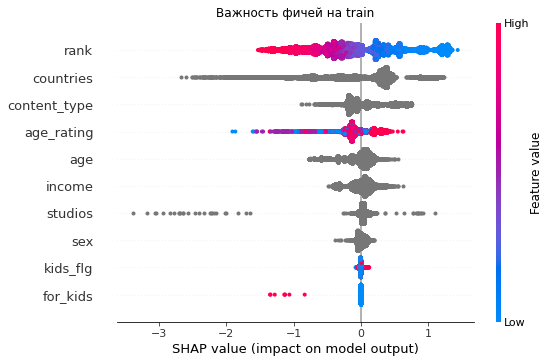

In [50]:
plt.title("Важность фичей на train")

shap.summary_plot(
    shap_values,
    X_train_subs
)

## Оценим метрики catboost модели 

In [51]:
test_feat = ctb_test.merge(users[user_col],
                           on=['user_id'],
                           how='left')\
                    .merge(items[item_col],
                               on=['item_id'],
                               how='left')

In [52]:
# fillna for catboost with the most frequent value 
test_feat = test_feat.fillna(X_train.mode().iloc[0])

In [53]:
X_test, y_test = test_feat.drop(drop_col + target_col, axis=1), test_feat['target']

In [54]:
X_test.head()

,rank,age,income,sex,kids_flg,content_type,countries,for_kids,age_rating,studios
0,9,age_25_34,income_40_60,Ж,0.0,series,Россия,0.0,18.0,HBO
1,30,age_18_24,income_0_20,М,0.0,film,США,0.0,16.0,HBO
2,11,age_45_54,income_20_40,Ж,1.0,film,"Великобритания, США",0.0,18.0,HBO
3,2,age_35_44,income_20_40,Ж,0.0,series,Россия,0.0,18.0,HBO
4,1,age_25_34,income_40_60,Ж,0.0,series,Россия,0.0,18.0,HBO


In [55]:
y_pred = ctb_model.predict_proba(X_test)

In [56]:
from sklearn.metrics import roc_auc_score

f"ROC AUC score = {roc_auc_score(y_test, y_pred[:, 1]):.2f}"

'ROC AUC score = 0.76'

# Метрики качества на глобальном test

- Формируем рекомендации отдельно моделью 1 этапа - LightFM
- Отдельно двухэтапной моделью LightFM + Catboost 
- Сравниваем

## 1) Метрики качества LightFM

In [57]:
# оставляем только теплых пользователей
test = test[test['user_id'].isin(lfm_train['user_id'].unique())]

In [58]:
# кол-во кандидатов берем больше, чем для обучения
# чтобы катбусту было, что ранжировать
top_N = 200

lfm_prediction = pd.DataFrame({
    'user_id': test['user_id'].unique()
})

known_items = lfm_train.groupby('user_id')['item_id'].apply(list).to_dict()

mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=known_items,
    N=top_N,
    user_features=None, 
    item_features=None, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

lfm_prediction['item_id'] = lfm_prediction['user_id'].map(mapper)
lfm_prediction = lfm_prediction.explode('item_id').reset_index(drop=True)
lfm_prediction['rank'] = lfm_prediction.groupby('user_id').cumcount() + 1 

### `1 этап LightFM`: Метрики Precision@k, Recall@k, MAP@k, MRR

k = 1, .., 10

In [59]:
from tools import compute_metrics

lfm_metrics = compute_metrics(test[['user_id', 'item_id']],
                              lfm_prediction, 
                              top_N=10)
lfm_metrics

Precision@1     0.025763
Recall@1        0.014394
Precision@2     0.027750
Recall@2        0.030863
Precision@3     0.026736
Recall@3        0.044355
Precision@4     0.025767
Recall@4        0.056663
Precision@5     0.024799
Recall@5        0.067901
Precision@6     0.023232
Recall@6        0.075653
Precision@7     0.022068
Recall@7        0.082984
Precision@8     0.021082
Recall@8        0.090258
Precision@9     0.020011
Recall@9        0.095365
Precision@10    0.019074
Recall@10       0.100459
MAP@10          0.044134
MRR             0.072471
dtype: float64

## 2) Метрики качества двухэтапной модели: `LightFM` + `Catboost`

In [60]:
lfm_ctb_prediction = lfm_prediction.copy()

# фичи для теста
score_feat = lfm_ctb_prediction.merge(users[user_col],
                                   on=['user_id'],
                                   how='left')\
                                .merge(items[item_col],
                                       on=['item_id'],
                                       how='left')

# fillna for catboost with the most frequent value 
score_feat = score_feat.fillna(X_train.mode().iloc[0])

In [61]:
score_feat.head()

,user_id,item_id,rank,age,income,sex,kids_flg,content_type,countries,for_kids,age_rating,studios
0,203219,10440,1,age_35_44,income_20_40,Ж,0.0,series,Россия,0.0,18.0,HBO
1,203219,15297,2,age_35_44,income_20_40,Ж,0.0,series,Россия,0.0,18.0,HBO
2,203219,4151,3,age_35_44,income_20_40,Ж,0.0,series,Россия,0.0,18.0,HBO
3,203219,4880,4,age_35_44,income_20_40,Ж,0.0,series,Россия,0.0,18.0,HBO
4,203219,13865,5,age_35_44,income_20_40,Ж,0.0,film,Россия,0.0,12.0,HBO


In [62]:
# catboost predict_proba
ctb_prediction = ctb_model.predict_proba(score_feat.drop(drop_col, axis=1, errors='ignore'))

lfm_ctb_prediction['ctb_pred'] = ctb_prediction[:, 1]
lfm_ctb_prediction.head(3)

,user_id,item_id,rank,ctb_pred
0,203219,10440,1,0.709495
1,203219,15297,2,0.739416
2,203219,4151,3,0.666211


In [63]:
lfm_prediction.sort_values(
    by=['user_id'], ascending=[True]).head(10)

,user_id,item_id,rank
8807600,21,9728,1
8807728,21,6626,129
8807729,21,6968,130
8807730,21,308,131
8807731,21,10958,132
8807732,21,15656,133
8807733,21,3130,134
8807734,21,15918,135
8807735,21,13940,136
8807736,21,16080,137


### Проставляем итоговый ранк двухэтапной модели

In [64]:
# сортируем по скору внутри одного пользователя и проставляем новый ранг
lfm_ctb_prediction = lfm_ctb_prediction.sort_values(
    by=['user_id', 'ctb_pred'], ascending=[True, False])
lfm_ctb_prediction['rank_ctb'] = lfm_ctb_prediction.groupby('user_id').cumcount() + 1

In [65]:
lfm_ctb_prediction.head(10)

,user_id,item_id,rank,ctb_pred,rank_ctb
8807602,21,10440,3,0.644380,1
8807600,21,9728,1,0.583983,2
8807601,21,13865,2,0.528070,3
8807655,21,11754,56,0.515255,4
8807674,21,15739,75,0.515255,5
8807798,21,15362,199,0.515255,6
8807605,21,15297,6,0.471484,7
8807610,21,4151,11,0.442719,8
8807614,21,4880,15,0.413474,9
8807609,21,9214,10,0.324715,10


In [66]:
# интересно сравнить ранки 1 этапа lightfm и двухэтапной модели
pd.crosstab(lfm_ctb_prediction[lfm_ctb_prediction['rank'] <= 10]['rank'], 
            lfm_ctb_prediction[lfm_ctb_prediction['rank_ctb'] <= 10]['rank_ctb'])\
    .style.background_gradient(cmap='spring')

rank_ctb,1,2,3,4,5,6,7,8,9,10
rank,,,,,,,,,,
1,7778,15375,4952,792,680,815,729,595,421,311
2,20558,8781,3116,2546,1402,688,627,598,636,647
3,5366,9516,8659,6234,4728,1254,1264,1787,1400,1120
4,3519,4687,9304,7217,4728,1874,1669,2248,2103,1899
5,3995,2332,6145,6733,4251,2845,2735,3362,3196,2325
6,1572,1035,1778,2355,3211,4668,4356,3812,6315,4096
7,1411,779,1262,1642,2389,3124,3269,3519,3578,3308
8,1561,1189,2117,3192,4192,5182,4833,4046,4251,5384
9,1292,801,1326,1771,2293,2495,2896,3566,4165,3913


### `1+2 этапы LightFM + Сatboost`: Метрики 

k = 1, .., 10

In [67]:
model_2step_metrics = compute_metrics(test[['user_id', 'item_id']],
                                       lfm_ctb_prediction, 
                                       top_N=10, 
                                       rank_col='rank_ctb')
model_2step_metrics

Precision@1     0.050558
Recall@1        0.028258
Precision@2     0.044312
Recall@2        0.049841
Precision@3     0.039131
Recall@3        0.065340
Precision@4     0.034787
Recall@4        0.076902
Precision@5     0.031047
Recall@5        0.084809
Precision@6     0.028081
Recall@6        0.091305
Precision@7     0.025909
Recall@7        0.097297
Precision@8     0.024018
Recall@8        0.102356
Precision@9     0.022576
Recall@9        0.107597
Precision@10    0.021358
Recall@10       0.112307
MAP@10          0.059461
MRR             0.098538
dtype: float64

## 🧐 Сравнение метрик

In [68]:
df_metrics = pd.concat([
    pd.DataFrame(lfm_metrics).transpose(),
    pd.DataFrame(model_2step_metrics).transpose()
])

df_metrics.index = ['lightfm', 'model_2step']

df_metrics

,Precision@1,Recall@1,Precision@2,Recall@2,Precision@3,Recall@3,Precision@4,Recall@4,Precision@5,Recall@5,Precision@6,Recall@6,Precision@7,Recall@7,Precision@8,Recall@8,Precision@9,Recall@9,Precision@10,Recall@10,MAP@10,MRR
lightfm,0.025763,0.014394,0.027750,0.030863,0.026736,0.044355,0.025767,0.056663,0.024799,0.067901,0.023232,0.075653,0.022068,0.082984,0.021082,0.090258,0.020011,0.095365,0.019074,0.100459,0.044134,0.072471
model_2step,0.050558,0.028258,0.044312,0.049841,0.039131,0.065340,0.034787,0.076902,0.031047,0.084809,0.028081,0.091305,0.025909,0.097297,0.024018,0.102356,0.022576,0.107597,0.021358,0.112307,0.059461,0.098538


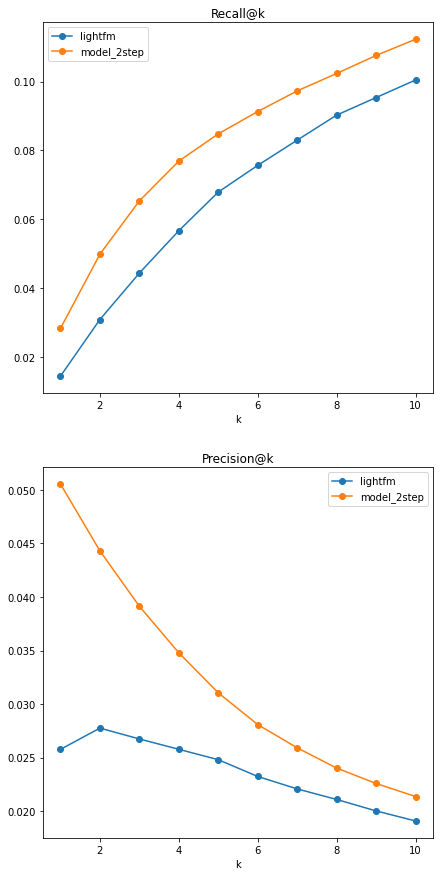

In [69]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(7, 15))

for indx, metric in enumerate([f'Recall@', f'Precision@']):
    for model in df_metrics.index:
        axes[indx].plot(range(1, 11), 
                        df_metrics.loc[model][[metric+f'{k}' for k in range(1, 11)]].values,
                        label=model, marker='o')
        axes[indx].legend()
        axes[indx].set_title(f'{metric}k')
        axes[indx].set_xlabel('k')

# Что дальше:
    
- подбирать соотношение train и test 
- кандидаты от нескольких моделей
- другие варианты сбора обучающей выборки для бустинга
- генерация признаков для бустинга
- валидировать итоговые метрики как тест = 1 день со сдвигом в 1 день и усреднять значения метрик за 7 дней

